In [1]:
import os
import time
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn import preprocessing

# Activer les optimisations de convolution GPU
torch.backends.cudnn.benchmark = True

# Définir les transformations pour les images d'entraînement et de validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Vérification des images pour identifier celles qui sont valides
def filter_valid_images(df, image_folder):
    valid_images = []
    for img_name in df['image']:
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()
                if min(img.size) >= 224:  # Vérifie que la dimension minimale est 224
                    valid_images.append(img_name)
        except Exception as e:
            print(f"Erreur avec {img_path}: {e}")
    return df[df['image'].isin(valid_images)]

# Charger les données et appliquer la vérification
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df['Category_Level_1'] = df['product_category_tree'].str.split('>>', expand=True)[0]
df['Category_Level_1'] = df['Category_Level_1'].str.replace('["', '', regex=False)
columns_of_interest = ['Category_Level_1', 'image']
df = df[columns_of_interest]
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["Category_Level_1"])
image_folder = '/Users/amira/Documents/OPC/Projet6/Images/'

# Filtrer les images valides
df = filter_valid_images(df, image_folder)
df['image_path'] = image_folder + df['image']

# Échantillonnage des données pour réduire le temps d'exécution
# Ajustez le frac (ex: 0.1 pour 10% des données)
sample_fraction = 0.3  # Prendre 30% des données
df = df.sample(frac=sample_fraction, random_state=42)  # Échantillonnage

# Classe de dataset personnalisée
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")
        label = self.df.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Diviser les données en ensembles d'entraînement et de validation
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# Initialiser une liste pour stocker les métriques
metrics_data = []

# Fonction d'entraînement sans sauvegarde des checkpoints
def train_model(model, train_loader, val_loader, epochs=5, model_name="Model"):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(epochs):
        start_epoch_time = time.time()

        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
        
        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # Temps d'exécution pour l'époque
        epoch_time = time.time() - start_epoch_time

        # Calcul des précisions et pertes moyennes
        train_accuracy = train_correct / len(train_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)

        # Stocker les métriques
        metrics_data.append({
            'Model': model_name,
            'Epoch': epoch + 1,
            'Train_Loss': avg_train_loss,
            'Train_Accuracy': train_accuracy,
            'Val_Loss': avg_val_loss,
            'Val_Accuracy': val_accuracy,
            'Epoch_Time': epoch_time,
            'Eval_Time': None
        })

        scheduler.step()

# Fonction d'évaluation
def evaluate_model(model, val_loader, model_name="Model"):
    start_eval_time = time.time()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    eval_time = time.time() - start_eval_time

    for entry in reversed(metrics_data):
        if entry['Model'] == model_name and entry['Eval_Time'] is None:
            entry['Eval_Time'] = eval_time
            break

    print(f"Précision finale ({model_name}) : {accuracy:.4f}")
    print(f"Temps total d'évaluation : {eval_time:.2f} secondes")

# Charger les modèles
vit_model = models.vit_b_16(pretrained=True)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, len(df['label'].unique()))

resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(df['label'].unique()))

# Entraîner et évaluer le Vision Transformer
print("Entraînement du Vision Transformer:")
train_model(vit_model, train_loader, val_loader, epochs=5, model_name="Vision Transformer")
evaluate_model(vit_model, val_loader, model_name="Vision Transformer")

# Entraîner et évaluer le ResNet50
print("Entraînement du ResNet50:")
train_model(resnet_model, train_loader, val_loader, epochs=5, model_name="ResNet50")
evaluate_model(resnet_model, val_loader, model_name="ResNet50")

# Convertir les données de métriques en DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprec

Entraînement du Vision Transformer:
Précision finale (Vision Transformer) : 0.8226
Temps total d'évaluation : 24.20 secondes
Entraînement du ResNet50:
Précision finale (ResNet50) : 0.8226
Temps total d'évaluation : 14.03 secondes


,Model,Epoch,Train_Loss,Train_Accuracy,Val_Loss,Val_Accuracy,Epoch_Time,Eval_Time
0,Vision Transformer,1,1.345721,0.562753,0.789167,0.790323,405.113929,NaN
1,Vision Transformer,2,0.246950,0.931174,0.671559,0.822581,370.631541,NaN
2,Vision Transformer,3,0.075348,0.987854,0.678207,0.758065,348.482568,NaN
3,Vision Transformer,4,0.026319,1.000000,0.782071,0.806452,390.435579,NaN
4,Vision Transformer,5,0.009461,1.000000,0.752815,0.822581,371.812286,24.200300
5,ResNet50,1,1.477388,0.546559,0.902826,0.822581,150.418094,NaN
6,ResNet50,2,0.491269,0.947368,0.627387,0.838710,156.720516,NaN
7,ResNet50,3,0.152201,0.987854,0.571273,0.838710,143.888302,NaN
8,ResNet50,4,0.049942,0.995951,0.575534,0.822581,147.393571,NaN
9,ResNet50,5,0.018518,1.000000,0.596974,0.822581,149.439985,14.031454


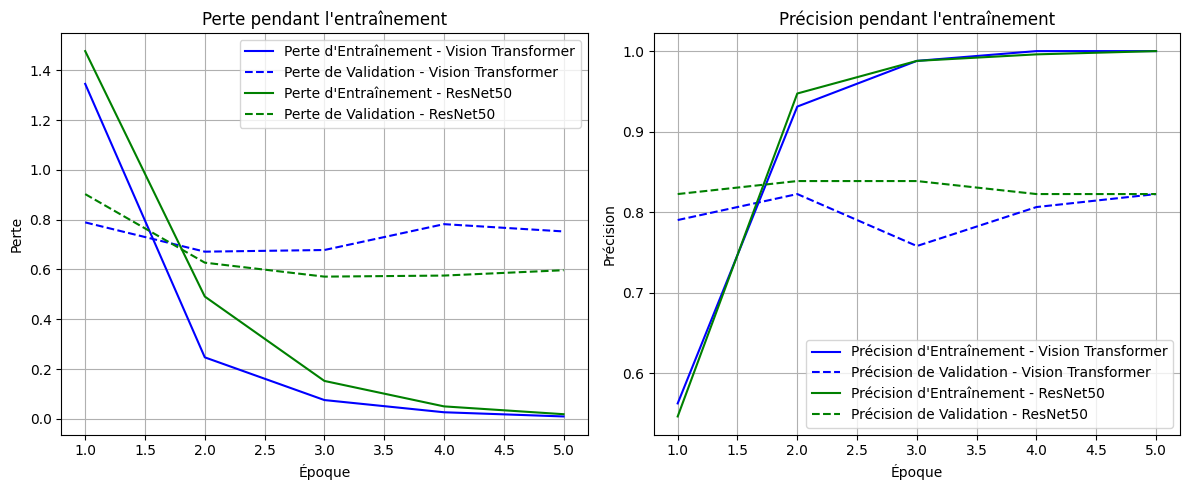

In [4]:
import matplotlib.pyplot as plt

# Tracer les courbes de la perte et de la précision pour les deux modèles
def plot_comparison(metrics_df, model_names):
    plt.figure(figsize=(12, 5))

    # Définir un dictionnaire de couleurs pour chaque modèle
    colors = {
        "Vision Transformer": "blue",
        "ResNet50": "green"
    }

    # Tracer la perte pour chaque modèle
    plt.subplot(1, 2, 1)
    for model_name in model_names:
        model_metrics = metrics_df[metrics_df['Model'] == model_name]
        plt.plot(model_metrics['Epoch'], model_metrics['Train_Loss'], label=f'Perte d\'Entraînement - {model_name}', color=colors[model_name], linestyle='-')
        plt.plot(model_metrics['Epoch'], model_metrics['Val_Loss'], label=f'Perte de Validation - {model_name}', color=colors[model_name], linestyle='--')
    plt.title('Perte pendant l\'entraînement')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid()

    # Tracer la précision pour chaque modèle
    plt.subplot(1, 2, 2)
    for model_name in model_names:
        model_metrics = metrics_df[metrics_df['Model'] == model_name]
        plt.plot(model_metrics['Epoch'], model_metrics['Train_Accuracy'], label=f'Précision d\'Entraînement - {model_name}', color=colors[model_name], linestyle='-')
        plt.plot(model_metrics['Epoch'], model_metrics['Val_Accuracy'], label=f'Précision de Validation - {model_name}', color=colors[model_name], linestyle='--')
    plt.title('Précision pendant l\'entraînement')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Liste des modèles à comparer
model_names = ["Vision Transformer", "ResNet50"]

# Tracer les résultats pour la comparaison des modèles
plot_comparison(metrics_df, model_names)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torchvision.transforms.functional import to_pil_image

# Fonction Grad-CAM pour ViT
def compute_gradcam(model, input_image, target_layer, target_class):
    model.eval()
    # Passage en mode evaluation et calcul des gradients
    model.zero_grad()
    activation = {}
    gradients = {}
    
    def forward_hook(module, input, output):
        activation['value'] = output

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0]

    # Enregistrement des hooks
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)
    
    output = model(input_image.unsqueeze(0))
    target = output[0, target_class]
    target.backward()
    
    # Récupérer les gradients et activations
    grads = gradients['value']
    activations = activation['value']
    
    # Calcul de Grad-CAM
    pooled_grad = torch.mean(grads, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grad[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap /= torch.max(heatmap)
    
    return heatmap

# Application sur une image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = "chemin/vers/votre/image.jpg"  # Chemin de l'image
image = Image.open(image_path).convert("RGB")
input_image = transform(image)

# Application de Grad-CAM
target_layer = vit_model.encoder.layer[-1]  # Dernière couche pour ViT
target_class = 0  # Classe cible pour laquelle on veut générer la heatmap
heatmap = compute_gradcam(vit_model, input_image, target_layer, target_class)

# Affichage de la heatmap
heatmap = to_pil_image(heatmap)
heatmap = heatmap.resize(image.size, Image.BILINEAR)
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Créer un explainer LIME pour les images
explainer = lime_image.LimeImageExplainer()

# Obtenir une explication LIME pour une image spécifique
explanation = explainer.explain_instance(
    np.array(image),  # Image d'origine non transformée
    vit_model.predict,  # Fonction de prédiction
    top_labels=1,  # Nombre de classes à expliquer
    hide_color=0,
    num_samples=1000  # Nombre d'échantillons de perturbations
)

# Affichage de l'explication LIME pour la classe prédite
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()
